In [1]:
import os
import sys
import cv2
import numpy as np
import torch
import torchvision
import paddle
import matplotlib.pyplot as plt
%matplotlib inline

grep: warning: GREP_OPTIONS is deprecated; please use an alias or script


In [2]:
print(paddle.__version__)
print(torch.__version__)

2.1.2
1.9.0


In [4]:
conv_paddle = paddle.nn.Conv2D(
    in_channels=3,
    out_channels=4,
    kernel_size=1,
    stride=1)
conv_torch = paddle.nn.Conv2D(
    in_channels=3,
    out_channels=4,
    kernel_size=1,
    stride=1)
print(conv_paddle)
print(conv_torch)

Conv2D(3, 4, kernel_size=[1, 1], data_format=NCHW)
Conv2D(3, 4, kernel_size=[1, 1], data_format=NCHW)


In [9]:
linear_paddle = paddle.nn.Linear(
    in_features=10,
    out_features=20)
linear_torch = torch.nn.Linear(
    in_features=10,
    out_features=20)
print(linear_paddle)
print(linear_torch)
print("====linear_paddle info====")
for name, weight in linear_paddle.named_parameters():
    print(name, weight.shape)
print("\n====linear_torch info====")
for name, weight in linear_torch.named_parameters():
    print(name, weight.shape)

Linear(in_features=10, out_features=20, dtype=float32)
Linear(in_features=10, out_features=20, bias=True)
====linear_paddle info====
weight [10, 20]
bias [20]

====linear_torch info====
weight torch.Size([20, 10])
bias torch.Size([20])


In [25]:
# 下载到默认路径
dataset_paddle = paddle.vision.datasets.Cifar10(
    mode="train",
    download=True)
# 下载到data目录
dataset_torch = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True)
print(dataset_paddle)
print(dataset_torch)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train


paddle length:  50000
torch length:  50000


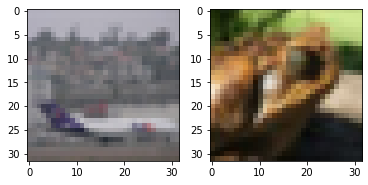

In [29]:
print("paddle length: ", len(dataset_paddle))
print("torch length: ", len(dataset_torch))
plt.subplot(121)
plt.imshow(dataset_paddle[0][0])
plt.subplot(122)
plt.imshow(dataset_paddle[1][0])
plt.show()

In [40]:
x = np.random.rand(32, 10).astype(np.float32)
label = np.random.randint(0, 10, [32, ], dtype=np.int64)

ce_loss_paddle = paddle.nn.CrossEntropyLoss()
ce_loss_torch = torch.nn.CrossEntropyLoss()

loss_paddle = ce_loss_paddle(
    paddle.to_tensor(x),
    paddle.to_tensor(label))
loss_torch = ce_loss_torch(
    torch.from_numpy(x),
    torch.from_numpy(label))

print(loss_paddle)
print(loss_torch)

Tensor(shape=[1], dtype=float32, place=CPUPlace, stop_gradient=True,
       [2.27016926])
tensor(2.2702)


In [4]:
x = np.random.rand(4, 10).astype(np.float32)
label = np.random.randint(0, 10, [4, ], dtype=np.int64)

score_paddle, cls_id_paddle  = paddle.topk(paddle.to_tensor(x), k=1)
score_torch, cls_id_torch = torch.topk(torch.from_numpy(x), k=1)
print("====class ids diff=====")
print(cls_id_paddle.numpy().tolist())
print(cls_id_torch.numpy().tolist())
print("\n====socres diff=====")
print(score_paddle.numpy().tolist())
print(score_torch.numpy().tolist())

====class ids diff=====
[[9], [7], [0], [8]]
[[9], [7], [0], [8]]

====socres diff=====
[[0.9987384080886841], [0.9276436567306519], [0.972288191318512], [0.897953987121582]]
[[0.9987384080886841], [0.9276436567306519], [0.972288191318512], [0.897953987121582]]


In [36]:
linear_paddle = paddle.nn.Linear(10, 10)
lr_sch_paddle = paddle.optimizer.lr.StepDecay(
    0.1,
    step_size=1,
    gamma=0.1)
opt_paddle = paddle.optimizer.Momentum(
    learning_rate=lr_sch_paddle,
    parameters=linear_paddle.parameters(),
    weight_decay=0.01)

linear_torch = torch.nn.Linear(10, 10)
opt_torch = torch.optim.SGD(
    linear_torch.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=0.1)
lr_sch_torch = torch.optim.lr_scheduler.StepLR(
    opt_torch,
    step_size=1, gamma=0.1)

for idx in range(1, 4):
    lr_sch_paddle.step()
    lr_sch_torch.step()
    print("step {}, paddle lr: {:.6f}, torch lr: {:.6f}".format(
        idx,
        lr_sch_paddle.get_lr(),
        lr_sch_torch.get_lr()[0]))

step 1, paddle lr: 0.010000, torch lr: 0.001000
step 2, paddle lr: 0.001000, torch lr: 0.000100
step 3, paddle lr: 0.000100, torch lr: 0.000010


In [37]:
class PaddleModel(paddle.nn.Layer):
    def __init__(self):
        super().__init__()
        self.conv = paddle.nn.Conv2D(
            in_channels=3,
            out_channels=12,
            kernel_size=3,
            padding=1,
            dilation=0)
        self.bn = paddle.nn.BatchNorm2D(12)
        self.relu = paddle.nn.ReLU()
        self.maxpool = paddle.nn.MaxPool2D(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x


class TorchModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(
            in_channels=3,
            out_channels=12,
            kernel_size=3,
            padding=1)
        self.bn = torch.nn.BatchNorm2d(12)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1)

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.bn_layer(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

paddle_model = PaddleModel()
torch_model = TorchModel()
print(paddle_model)
print(torch_model)

PaddleModel(
  (conv): Conv2D(3, 12, kernel_size=[3, 3], padding=1, dilation=[0, 0], data_format=NCHW)
  (bn): BatchNorm2D(num_features=12, momentum=0.9, epsilon=1e-05)
  (relu): ReLU()
  (maxpool): MaxPool2D(kernel_size=3, stride=2, padding=1)
)
TorchModel(
  (conv): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
)


In [38]:
print("====paddle names====")
print(list(paddle_model.state_dict().keys()))
print("\n====torch names====")
print(list(torch_model.state_dict().keys()))

====paddle names====
['conv.weight', 'conv.bias', 'bn.weight', 'bn.bias', 'bn._mean', 'bn._variance']

====torch names====
['conv.weight', 'conv.bias', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var', 'bn.num_batches_tracked']


In [4]:
def clip_funny(x, minv, maxv):
    midv = (minv + maxv) / 2.0
    cond1 = paddle.logical_and(x > minv, x < midv)
    cond2 = paddle.logical_and(x >= midv, x < maxv)
    
    y = paddle.where(cond1, paddle.ones_like(x) * minv, x)
    y = paddle.where(cond2, paddle.ones_like(x) * maxv, y)
    return y

x = paddle.to_tensor([1, 2, 2.5, 2.6, 3, 3.5])
y = clip_funny(x, 2, 3)
print(y)

Tensor(shape=[6], dtype=float32, place=CUDAPlace(0), stop_gradient=True,
       [1.        , 2.        , 3.        , 3.        , 3.        , 3.50000000])
